In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# cwd
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

/var/folders/83/j83q5_mj11956_7k9tnld0ym0000gn/T/ipykernel_51872/3914640498.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Current working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling/notebooks
New working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling


In [2]:
from cdi.plotters import Plotters

plotter = Plotters()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


SA --> surface area 
DG --> defect ratio
%N --> percent nitrogen
%O --> percent oxygen
%S --> percent sulphur
CD --> current density
CONC --> concentration of electrolyte
CAP --> specific capacitance

In [3]:
import pandas as pd

desired_columns = ['VW', 'FR', 'CNaCl', 'SSA', 'PV', 'Psave', 'PVmicro', 'ID/IG', 'N', 'O', 'EC']

data = pd.read_excel('data/not_time_series/cdi_data.xlsx', sheet_name='data_cleaned')
data = data[desired_columns]
print(data.shape)
data.head()

(583, 11)


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
0,1.2,9.0,390.0,651.0,0.50,3.07,0.18,NaN,NaN,NaN,6.40
1,1.2,9.0,390.0,512.0,0.29,2.27,0.23,NaN,NaN,NaN,4.60
2,1.0,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,10.00
3,0.6,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,5.63
4,0.8,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,8.20


In [4]:
data.describe().to_excel("./data/generated/salt_adsorption_data_description.xlsx")

In [5]:
# drop missing values
clean_data = data.dropna()
print(clean_data.shape)
clean_data.head()

(105, 11)


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
20,1.0,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,13.30
21,1.1,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,5.30
22,1.2,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,3.10
183,2.0,10.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,7.25
184,2.0,15.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,6.55


# Imputation

In [6]:
import pandas as pd
import numpy as np
from loguru import logger
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from cdi.dataPreprocessing import Imputation

In [7]:
method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=200)

IMPUTER = Imputation(data=data, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-08 15:12:47.565 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:     VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG    N   O     EC
0  1.2   9.0  390.0   651.0  0.50   3.07     0.18    NaN  NaN NaN   6.40
1  1.2   9.0  390.0   512.0  0.29   2.27     0.23    NaN  NaN NaN   4.60
2  1.0  25.0  292.0  1877.0  2.40   5.11     0.30   0.92  4.6 NaN  10.00
3  0.6  25.0  292.0  1877.0  2.40   5.11     0.30   0.92  4.6 NaN   5.63
4  0.8  25.0  292.0  1877.0  2.40   5.11     0.30   0.92  4.6 NaN   8.20
2024-02-08 15:12:47.566 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-08 15:12:47.566 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 583
2024-02-08 15:12:47.567 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-08 15:12:47.567 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 8
2024-02-08 15:12:47.568 | WARNING  | cdi.dataPreprocessi

<Axes: >

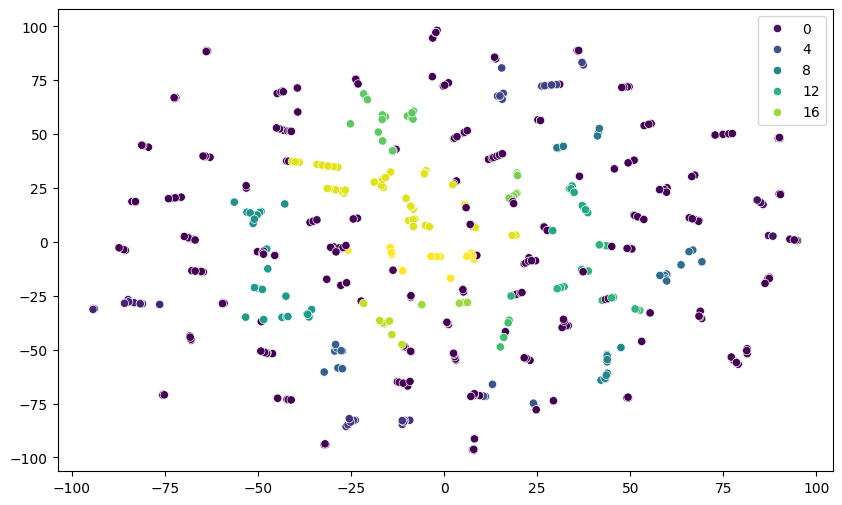

In [8]:
# tSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=104, perplexity=2, n_iter=1000)
tsne_data = tsne.fit_transform(df_imputed.iloc[:, :-1].values)

# cluster
from sklearn.cluster import HDBSCAN
cluster = HDBSCAN(min_cluster_size=5, min_samples=10)
cluster.fit(tsne_data)

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=cluster.labels_, palette='viridis')

# ML model

In [9]:
# Import Libraries
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from datetime import datetime
from keras import backend as K
# https://github.com/keras-team/keras/issues/7947

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


In [10]:
# # save params
# params_dict returned
#     {'num_layers': 5,
#     'units_0': 50,
#     'learning_rate': 0.01,
#     'units_1': 50,
#     'units_2': 50,
#     'units_3': 50,
#     'units_4': 50}

In [11]:
def build_model():
    # {'num_layers': 5,c'units_0': 50, 'learning_rate': 0.01, 'units_1': 50,
    #'units_2': 50, 'units_3': 50, 'units_4': 50}
    model = Sequential()
    model.add(Dense(50, input_dim=10, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(keras.layers.Dense(1, activation='linear'))

    model.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.001),
                          loss="mean_squared_error", 
                          metrics=["mean_squared_error", rmse, r_square])
    
    return model


In [12]:
# Create a new model for transfer learning
reloaded_TargetModel = build_model()

In [13]:
# Restore the weights
reloaded_TargetModel.load_weights('./models/salt_adsorption_capacity_target_model_ETR_imputation_approach.h5')
reloaded_TargetModel.get_weights()

[array([[ 7.30105191e-02, -3.98284830e-02, -2.49535307e-01,
         -6.82965338e-01,  6.46756217e-02,  2.35573668e-02,
         -9.93414372e-02, -4.66385454e-01,  8.44005942e-02,
          2.09425181e-01,  1.22615159e-01,  6.43149614e-02,
          1.79104641e-01,  1.02792121e-01, -2.92110771e-01,
         -1.44299194e-01, -6.45252392e-02, -6.45104289e-01,
         -7.85459876e-02, -2.74360608e-02,  1.72201574e-01,
          1.86884135e-01, -1.27290085e-01,  4.70453024e-01,
          3.06191236e-01,  7.14709461e-02,  8.66764724e-01,
          1.31259501e-01, -6.53541565e-01, -2.40392029e-01,
          1.50198430e-01, -5.29785529e-02, -4.63196605e-01,
          3.76972146e-02, -3.86178233e-02,  7.71702707e-01,
          4.97720391e-01,  1.30504787e-01, -1.17267740e+00,
          2.38170791e-02,  1.88572973e-01, -1.15729558e+00,
          2.11943239e-01,  8.42000544e-02,  2.53477655e-02,
         -8.13117847e-02, -2.60567307e-01, -2.85779446e-01,
         -1.62371751e-02, -2.12565228e-0

# Optimization

In [14]:
def plot_elbow(distances, threshold, name = 'elbow', save_fig: bool = False):

        fig = plt.figure(figsize=(10, 4))

        axs = fig.add_subplot(111) 

        distances = np.sort(distances[distances != 0])

        axs.plot(
                distances,
                color = 'purple')

        axs.plot(
                [0, len(distances)],
                [threshold, threshold],
                color = 'r',
                linestyle = '--',
                label = 'knn distance threshold')


        axs.set_xlabel(r'$\rm Sample$', labelpad=5, fontsize='x-large')
        axs.set_ylabel(r'$\rm kNN\ distance$', labelpad=5, fontsize='x-large')

        #axs = self.ax_formatter(axs, xax=False)
        axs.legend(frameon=False, ncol=2)

        if save_fig:
            plt.savefig(
                f'./reports/images/{name}.png',
                transparent=True,
                bbox_inches='tight')

        plt.show()
        return None

In [15]:
def plot_pareto(res, threshold, 
                ylabel = r'$\rm Peak\ power\ density\ (W/cm^{2})$',
                name = 'opt_test', save_fig: bool = False):
        fig = plt.figure(figsize=(7, 5))
        axs = fig.add_subplot(1, 1, 1)

        axs.scatter(res.F[:, 1], -res.F[:, 0], color = 'red', edgecolors = 'k')

        axs.set_xlabel(r'$\rm kNN\ distance$',
                                labelpad=5,
                                fontsize='x-large')

        axs.set_ylabel(ylabel,
                        labelpad=5,
                        fontsize='x-large')


        #axs = self.ax_formatter(axs, xax=False)

        axs.axvspan(min(res.F[:, 1]),
                            threshold,
                            facecolor='lightsteelblue',
                            alpha=0.3)

        axs.axvspan(threshold,
                            2*threshold,
                            facecolor='cornflowerblue',
                            alpha=0.3)

        axs.axvspan(2*threshold,
                            axs.get_xlim()[1],
                            facecolor='royalblue',
                            alpha=0.3)

        axs.text(min(res.F[:, 1]) + 0.05, max(-res.F[:, 0])*0.98, 'I')
        axs.text(threshold + 0.05, max(-res.F[:, 0])*0.98, 'II')
        axs.text(2*threshold + 0.05, max(-res.F[:, 0])*0.98, 'III')

        #plt.legend(frameon=False)
        axs.set_ylim(min(-res.F[:, 0]), max(-res.F[:, 0])+0.05)
        axs.set_xlim(min(res.F[:, 1]), max(res.F[:, 1]))

        if save_fig:
            plt.savefig(
                f'./reports/images/{name}.png',
                transparent=True,
                bbox_inches='tight')
        plt.show()

        return None

In [16]:
training_data = df_imputed.iloc[:, :-1]
training_data.head()

,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O
0,1.2,9.0,390.0,651.0,0.50,3.07,0.18,0.9205,0.8275,6.9995
1,1.2,9.0,390.0,512.0,0.29,2.27,0.23,0.9190,0.9070,7.1340
2,1.0,25.0,292.0,1877.0,2.40,5.11,0.30,0.9200,4.6000,6.6505
3,0.6,25.0,292.0,1877.0,2.40,5.11,0.30,0.9200,4.6000,6.6965
4,0.8,25.0,292.0,1877.0,2.40,5.11,0.30,0.9200,4.6000,6.8090


Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


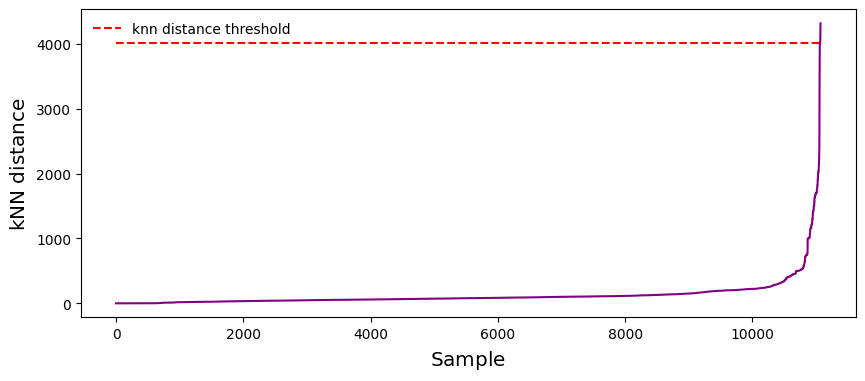

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


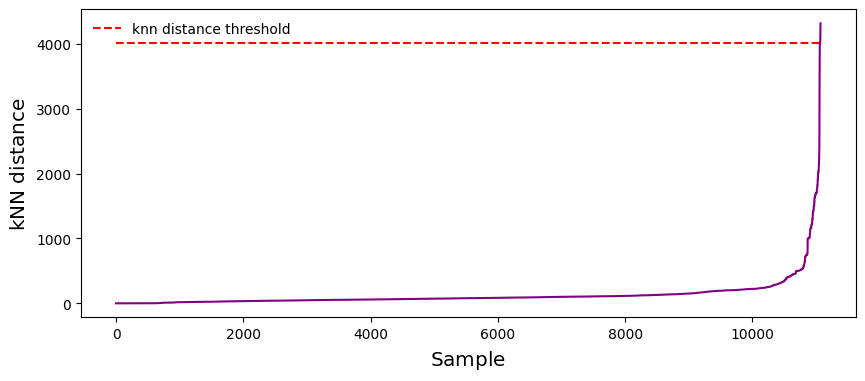

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


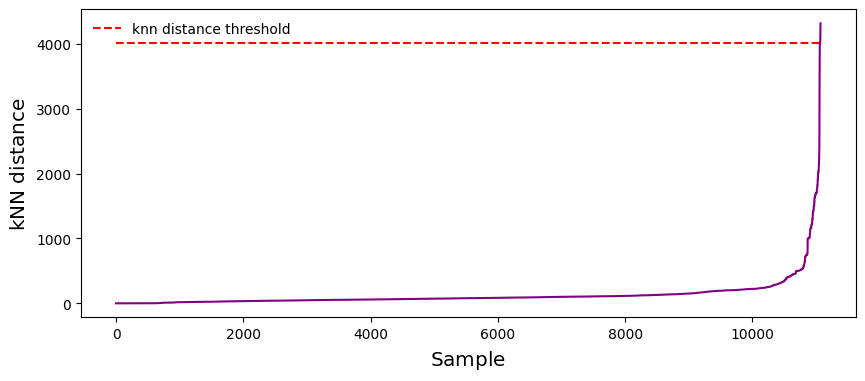

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


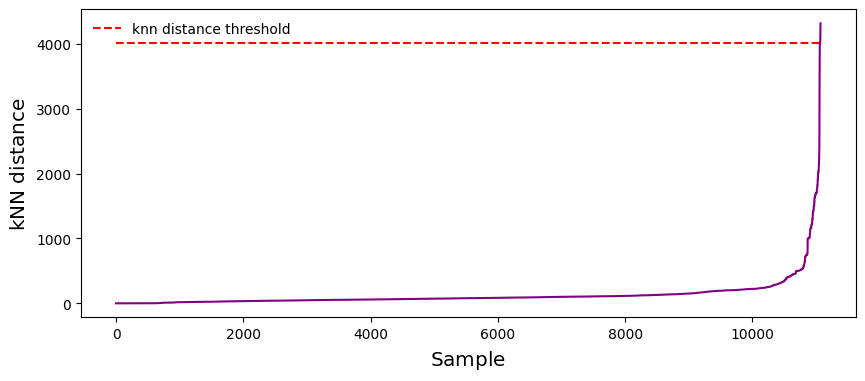

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


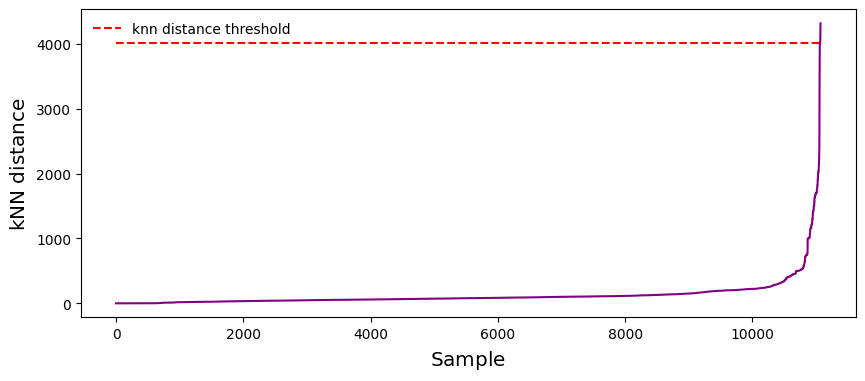

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


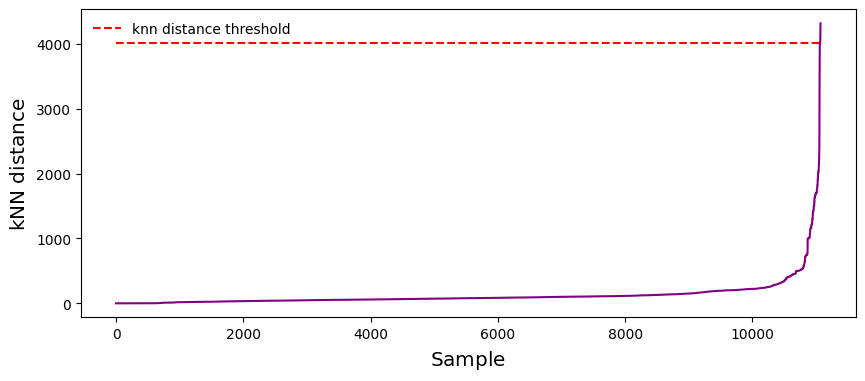

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


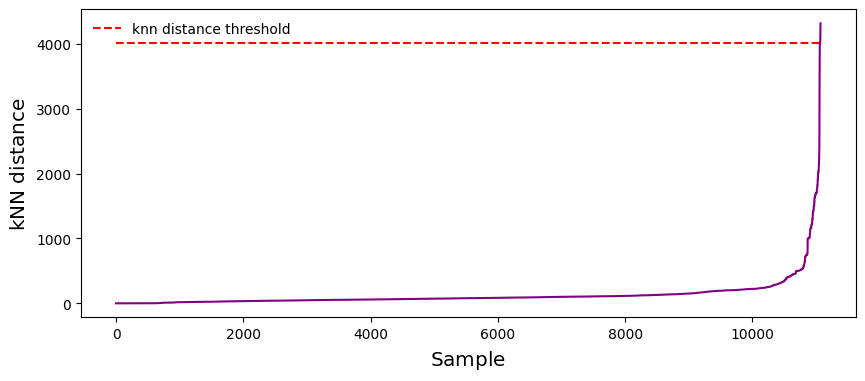

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


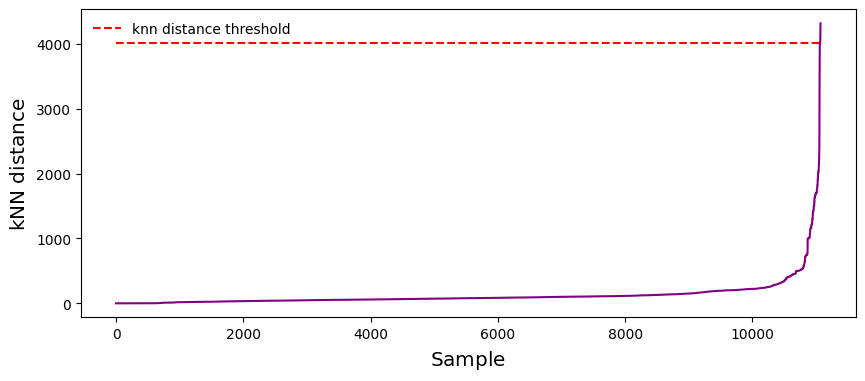

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


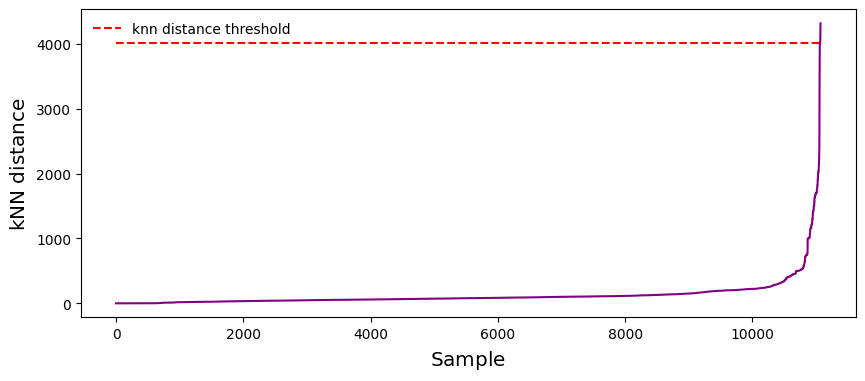

Threshold: 4022.335924371895
Shape of distances: (583, 20)
[[    0     1     2 ... 11657 11658 11659]]


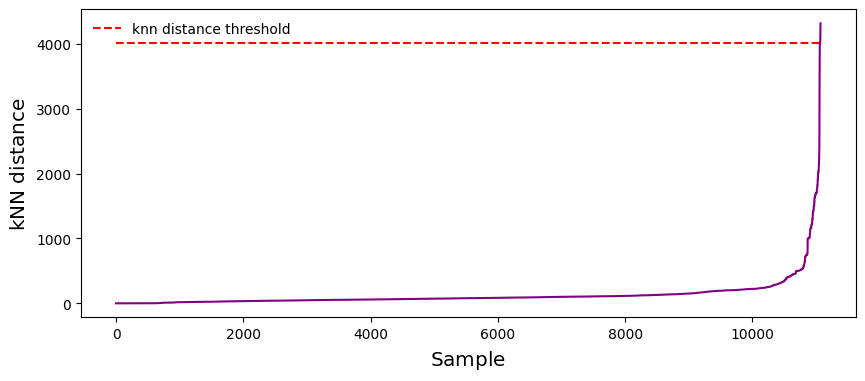

Threshold: 4022.335924371895


In [17]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from kneed import KneeLocator

def get_threshold(training_data, n_neighbors=20, figure_name=None):

    # get training data and compute kNN distance
    # sort

    nbrs = NearestNeighbors(n_neighbors = n_neighbors).fit(training_data)
    distances, indices = nbrs.kneighbors(training_data)

    print(f'Shape of distances: {distances.shape}')

    distances = distances.flatten()
    #plt.plot_elbow(distances)

    print(np.indices(distances.shape))

    kneedle = KneeLocator(np.indices(distances.shape)[0], distances, S=1.0, curve="convex", direction="increasing")

    threshold = np.sort(distances)[kneedle.knee]

    plot_elbow(distances = distances, threshold = threshold, name=figure_name)

    return threshold, nbrs

for k in range(1, 50, 5):
    threshold, nbrs = get_threshold(training_data.values)
    print(f"Threshold: {threshold}")

Shape of distances: (583, 15)
[[   0    1    2 ... 8742 8743 8744]]


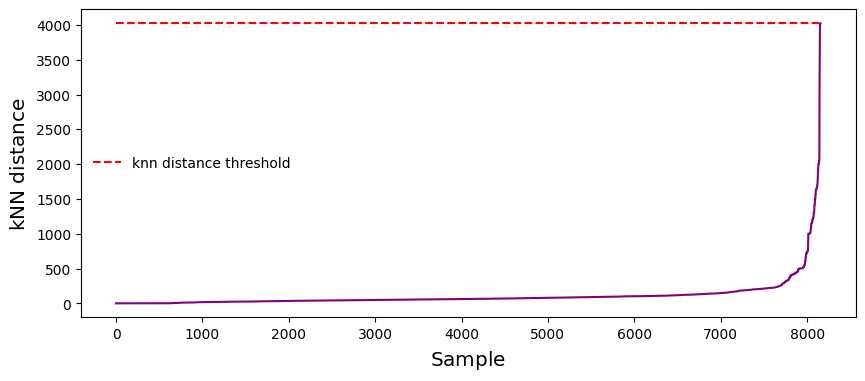

Threshold: 4022.335924371895


In [18]:
threshold, nbrs = get_threshold(training_data.values, n_neighbors=15,
                    figure_name='target_domain-elbow-plot')

print(f"Threshold: {threshold}")

In [19]:
import time
import warnings

import numpy as np

import torch
from kneed import KneeLocator
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.core.problem import ElementwiseProblem
# from pymoo.factory import (get_crossover, get_mutation, get_sampling,
#                            get_termination)
# from pymoo.operators.mixed_variable_operator import (MixedVariableCrossover,
#                                                      MixedVariableMutation,
#                                                      MixedVariableSampling)
# from pymoo.optimize import minimize
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore", category=RuntimeWarning)
start_time = time.time()

class DeviceOptimizer():

    def __init__(self, training_data = None, *args, **kwargs):

        if training_data is not None:
            self.distances, self.threshold, self.nbrs = self.get_threshold(training_data = training_data)

    def get_threshold(self, training_data, neighbors=100):
        """
        It takes in a training data set, computes the kNN distance, sorts the distances, and then finds the
        knee point of the sorted distances.

        The knee point is the point where the curve changes from being linear to being exponential.

        :param training_data: the data that we want to find the threshold for
        :return: The distances, the threshold, and the nbrs
        """

        # get training data and compute kNN distance
        # sort
        print(training_data)
        nbrs = NearestNeighbors(n_neighbors = neighbors).fit(training_data)
        distances, indices = nbrs.kneighbors(training_data)

        print(distances)

        distances = distances.flatten()

        kneedle = KneeLocator(np.indices(distances.shape)[0], distances, S=1.0, curve="convex", direction="increasing")

        threshold = np.sort(distances)[kneedle.knee]

        print(f'Original threshold: {threshold}')

        return distances, threshold, nbrs


    def ood(self, x, nbrs, threshold):
        """
        > If the maximum distance between the input and its nearest neighbors is greater than twice the
        threshold, then the input is considered out of distribution

        :param x: the data point we want to classify
        :param nbrs: the kNN model
        :param threshold: the threshold for the distance to the nearest neighbor. If the distance is
        greater than 2*threshold, then the point is considered out of distribution
        :return: a boolean value and the distance.
        """
        out_of_distribution = False

        distances, indices = nbrs.kneighbors(x.reshape(1, -1))

        distance = max(distances[0])

        #print(f'kNN distance = {distance}')

        if distance > 2*threshold:
                out_of_distribution = True

        return out_of_distribution, distance

In [20]:
# load scaler
import pickle
scaler_name =  '2024-02-04_actual_specific_adsortion_capacity_scaler_seed104_train_size75.0percent'
scaler = pickle.load(open(f'./models/{scaler_name}.pkl', 'rb'))

In [21]:
def obj_func(X): # model_predict
    # 
    #X = np.asarray(X) 

    inputs_ =  scaler.transform(X)
    
    output = reloaded_TargetModel.predict(inputs_)

    return output.flatten()

In [22]:
x = np.random.rand(1, 10)
print(x)
x_df = pd.DataFrame(x, columns=training_data.columns)
print(x.shape)
obj_func(x_df)

[[0.75552487 0.28537792 0.5093963  0.67156724 0.88126703 0.99620275
  0.38206367 0.83936155 0.29753033 0.16188901]]
(1, 10)
1/1 [==============================] - 0s 67ms/step


array([2.8724766], dtype=float32)

In [23]:
x = [0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
print(len(x))
x_df = pd.DataFrame([x], columns=training_data.columns)
obj_func(x_df)

10
1/1 [==============================] - 0s 15ms/step


array([257.82632], dtype=float32)

4/4 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Actual EC')

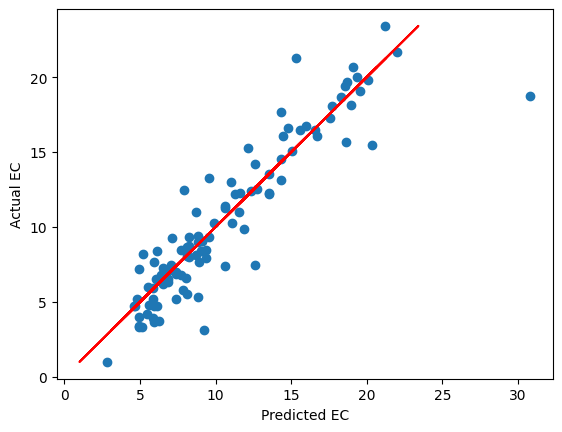

In [24]:
plt.scatter(obj_func(clean_data.iloc[:, :-1]), clean_data['EC'])
plt.plot(clean_data['EC'], clean_data['EC'], color='r')

plt.xlabel('Predicted EC')
plt.ylabel('Actual EC')

In [25]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VW,583.0,1.255918,0.295897,0.40,1.200,1.20,1.400,2.00
FR,575.0,28.266887,17.789518,2.50,15.000,25.00,40.000,100.00
CNaCl,583.0,386.287736,380.775709,20.00,100.000,292.50,500.000,5000.00
SSA,583.0,1119.613516,773.893744,4.50,586.900,907.00,1450.600,4482.00
PV,573.0,0.947818,0.661125,0.02,0.500,0.78,1.250,4.20
Psave,581.0,4.354802,4.170144,0.00,2.070,2.89,4.870,23.71
PVmicro,263.0,0.348327,0.273427,0.00,0.130,0.27,0.500,1.06
ID/IG,401.0,1.027160,0.193679,0.52,0.910,1.02,1.100,1.62
N,426.0,3.411690,3.705223,0.00,0.000,2.67,4.900,14.33
O,411.0,8.157360,4.710666,0.00,5.300,7.70,10.240,32.09


In [26]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.core.mixed import (MixedVariableMating, MixedVariableSampling, 
                            MixedVariableDuplicateElimination)
from pymoo.optimize import minimize

class salt_adsorption_case(ElementwiseProblem):
    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj = 2, n_constr = 1, vtype=float)

        self.xl = np.array([
                            0.40, 2.50, 20.00, 4.50, 0.02, 
                            0.00, 0.0, 0.52, 0.00, 0.00])
        self.xu = np.array([
                            2, 100, 5000.00, 4482.00, 4.20, 
                            23.71, 1.06, 1.62, 14.33, 32.09])
    
    def _evaluate(self, X, out, *args, **kwargs):

        features = np.asarray([
                                X[0], X[1], X[2], X[3], X[4], 
                                X[5], X[6], X[7], X[8], X[9]])

        dop = DeviceOptimizer()
        ood, distance = dop.ood(x = np.asarray(features), nbrs = nbrs, threshold = threshold)
        # objective functions
        f1 = obj_func(pd.DataFrame([features], columns=list(training_data.columns))) # maximize salt adsorption capacity
        f2 = np.array(distance).reshape(1, )  # minimize distance to the nearest neighbor
        f3 = -f1 # f1 >= 0, -f1 <= 0

        if ood == True:
            f1 = 1000
 
        
        out["F"] = [-f1, f2]
        out["G"] = [f3]

problem = salt_adsorption_case()
algorithm = AGEMOEA2(pop_size=50)
result = minimize(problem, 
                  algorithm, ('n_gen', 100), 
                  seed=1, save_history=True, verbose=True)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

1/1 [==============================] - 0s 8ms/step
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
1/1 [==============================] - 0s 9ms/step
     2 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |  0.2539016668 |         ideal
1/1 [==============================] - 0s 8ms/step
     3 |      150 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1419065145 |         ideal
1/1 [==============================] - 0s 8ms/step
     4 |      200 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0190874261 |         ideal
1/1 [==============================] - 0s 8ms/step
     5 |      250 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1684301354 |       

In [27]:
np.asarray(-result.F[:, 0]).reshape(-1,) * 1e-2

array([1.09189453, 0.40003326, 1.38871277, 0.69484375, 1.54117325,
       1.45798584, 1.93679062, 0.54637642, 1.51002258, 1.53402939,
       0.54830826, 1.32334167, 1.27184509, 1.05608673, 1.98864807,
       0.84937653, 0.95490036, 0.49490925, 0.77915115, 0.54071487,
       0.99921661, 1.13145699, 2.01545135, 1.41801163, 0.55048882,
       0.48144836, 1.56286896, 0.47227913, 1.43048553, 1.7898465 ,
       0.93042488, 0.40046703, 1.45860245, 1.3726387 , 0.50238628,
       0.37097046, 0.5106543 , 2.04629456, 1.29898743, 1.19990425,
       1.9783168 , 0.63011631, 0.51597618, 1.55586349, 0.54992813,
       0.921866  , 1.87467957, 1.95892303, 0.39476238, 0.5237043 ])

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.patches as patches

def plot_multi_ga(res, num_features: int = 10,
                  is_max: bool = True,
                  name = 'multi_ga',
                  save_fig: bool = False):
        
        # get the X and F values
        if is_max: 
            sol_array = np.asarray(-res.F[:, 0]).reshape(-1,) * 1e-2
        else:
            sol_array = np.asarray(res.F[:, 0]).reshape(-1,)

        pos_array = np.asarray(res.X).reshape(-1, num_features)
        pos_array = np.column_stack((pos_array, sol_array))

        x = np.arange(0, len(pos_array[0, :]))

        # y_axes names
        #[VW, FR, CNaCl, SSA, PV, Psave, PVmicro, ID_IG, N, O]
        all_labels = [
            r'$\rm VW$', r'$\rm FR$', r'$\rm CNaCl$', r'$\rm SSA$', 
            r'$\rm PV$', r'$\rm Psave$', r'$\rm PVmicro$', r'$\rm ID/IG$', 
            r'$\rm N\ content$', r'$\rm O\ content$', r'$\rm SAC$']

        all_units = [
            r'$\rm V$', r'$\rm ml/min$', r'$\rm mg/l$', r'$\rm m^{2}/g$', 
            r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm unitless$', 
            r'$\rm at.\%$', r'$\rm at.\%$',  r'$\rm mg/g$']

        labels = [f'{all_labels[i]}\n({all_units[i]})' for i in range(len(all_labels))]


        # Set up figure
        fig1 = plt.figure(figsize=(19, 7))
        ax1 = fig1.add_subplot(1, 1, 1)

        # organize the data
        xl = np.array([1.8, 2.5, 20, 4.5, 0.02, 0.00, 0.90, 0.52, 0.00, 0.00,
                        min(pos_array[:, -1]) - min(pos_array[:, -1])*0.004
                    ]).reshape(1, -1) 
        
        xu = np.array([2, 40, 5000.00, 4482.00, 4.20, 23.71, 1.5, 1.5, 16.00, 32.09,
                        max(pos_array[:, -1]) + max(pos_array[:, -1])*0.004
                        ]).reshape(1, -1)

        pos_array = np.vstack([pos_array, xl])
        pos_array = np.vstack([pos_array, xu])
        pos_array = pos_array[pos_array[:, -1].argsort()]
        
        ys = pos_array
        
        ymins = ys.min(axis=0)
        ymaxs = ys.max(axis=0)
        dys = ymaxs - ymins
        ymins += dys * 0.002  # add 5% padding below and above
        ymaxs -= dys * 0.002
        dys = ymaxs - ymins

        # transform all data to be compatible with the main axis
        zs = np.zeros_like(ys)
        zs[:, 0] = ys[:, 0]
        zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

        host = ax1
        ynames = labels

        axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
        for i, ax in enumerate(axes):
            #ax = self.ax_formatter(ax, xax=False)
            ax.set_ylim(ymins[i], ymaxs[i])
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if ax != host:
                ax.spines['left'].set_visible(False)
                ax.yaxis.set_ticks_position('right')
                ax.spines["right"].set_position(
                    ("axes", i / (ys.shape[1] - 1)))

        host.set_xlim(0, ys.shape[1] - 1)
        host.set_xticks(range(ys.shape[1]))
        host.set_xticklabels(ynames, fontsize=11)
        host.tick_params(axis='x', which='major', pad=7)
        host.spines['right'].set_visible(False)
        host.xaxis.tick_top()
        #host.set_title('Parallel Coordinates Plot', fontsize=18)

        colors = cm.magma(np.linspace(0, 1, len(pos_array[:, 0])+2))

        
        N = len(pos_array[:, 0])

        for j in range(N):

            verts = list(
                zip([
                    x for x in np.linspace(0,
                                            len(ys[0, :]) - 1,
                                            len(ys[0, :]) * 3 - 2,
                                            endpoint=True)
                ],
                    np.repeat(zs[j, :], 3)[1:-1]))
            # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
            codes = [Path.MOVETO
                        ] + [Path.CURVE4 for _ in range(len(verts) - 1)]
            path = Path(verts, codes)
            patch = patches.PathPatch(path,
                                        facecolor='none',
                                        lw=1.5,
                                        edgecolor=colors[j]#[j - 1]
                                        )
            host.add_patch(patch)
        
        norm = plt.Normalize(ymins[-1], ymaxs[-1])
        
        cbar = fig1.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=ax, pad = -0.008)
        cbar.ax.yaxis.set_ticks_position('right')
        cbar.ax.yaxis.set_ticklabels([])
        #cbar.ax = self.ax_formatter(cbar.ax, xax=False)

        cbar.ax.tick_params(
                         length=7)
        cbar.ax.tick_params(which='minor',
                         length=3)

        #host = self.ax_formatter(host, xax=False)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'/reports/images/{name}.png',
                    transparent=True,
                    bbox_inches='tight')
        
        return None

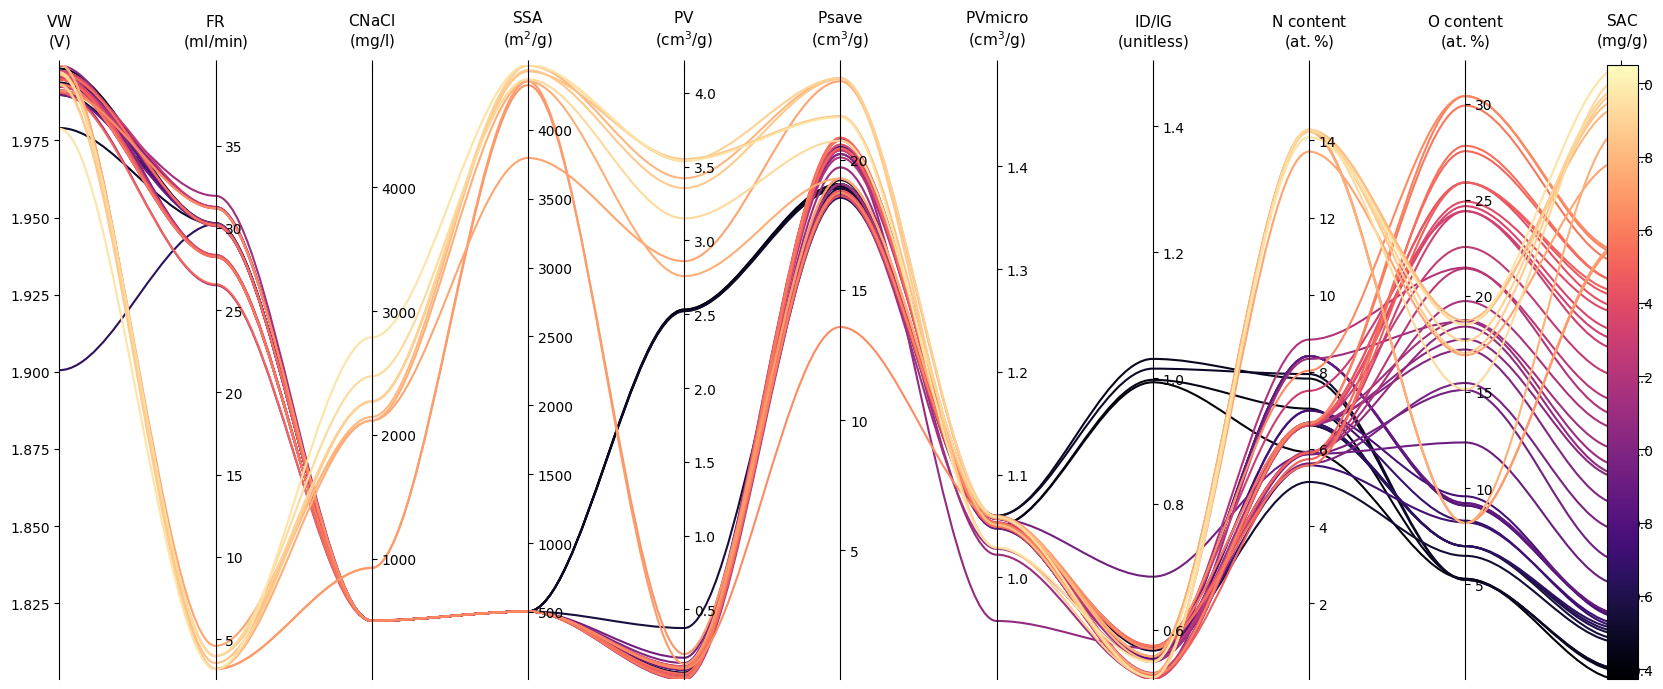

In [61]:
plot_multi_ga(result)

In [62]:
-1*result.F[:, 0]

array([109.18945312,  40.00332642, 138.87127686,  69.484375  ,
       154.11732483, 145.79858398, 193.67906189,  54.63764191,
       151.0022583 , 153.40293884,  54.83082581, 132.33416748,
       127.18450928, 105.6086731 , 198.86480713,  84.93765259,
        95.49003601,  49.49092484,  77.91511536,  54.07148743,
        99.92166138, 113.14569855, 201.5451355 , 141.80116272,
        55.04888153,  48.14483643, 156.28689575,  47.2279129 ,
       143.04855347, 178.98464966,  93.0424881 ,  40.04670334,
       145.86024475, 137.26387024,  50.23862839,  37.0970459 ,
        51.06542969, 204.62945557, 129.89874268, 119.99042511,
       197.8316803 ,  63.01163101,  51.5976181 , 155.58634949,
        54.99281311,  92.18659973, 187.46795654, 195.89230347,
        39.47623825,  52.37042999])

The function you have called (subplots_adjust) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues


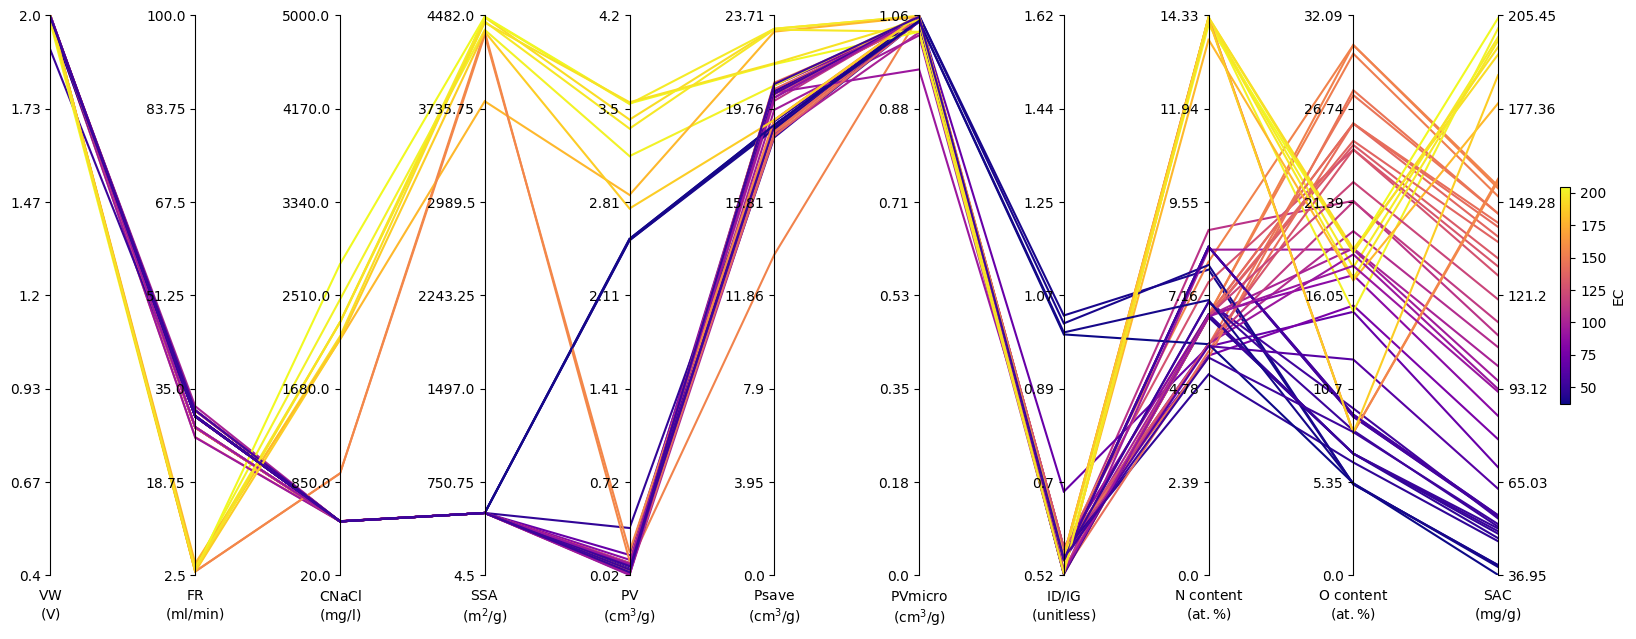

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import paxplot

dd = pd.DataFrame(result.X, columns=training_data.columns)
dd['EC'] = -result.F[:, 0]

cols = dd.columns

# Create figure
paxfig = paxplot.pax_parallel(n_axes=len(cols))
paxfig.plot(dd.to_numpy())

# Add labels
paxfig.set_labels(cols)

# Add colorbar
color_col = len(cols) - 1
paxfig.add_colorbar(ax_idx=color_col, cmap='plasma', colorbar_kwargs={'label': cols[color_col]})

# Set limits for each axis
lower_limit = {
                'VW': 0.40, 'FR': 2.50,
                'CNaCl': 20.00, 'SSA': 4.50,
                'PV': 0.02, 'Psave': 0.00,
                'PVmicro': 0.0, 'ID/IG': 0.52,
                'N': 0.00, 'O': 0.00,
                'EC': min(dd['EC']) - min(dd['EC'])*0.004
                }

upper_limit = {
                'VW': 2, 'FR': 100,
                'CNaCl': 5000.00, 'SSA': 4482.00,
                'PV': 4.20, 'Psave': 23.71,
                'PVmicro': 1.06, 'ID/IG': 1.62,
                'N': 14.33, 'O': 32.09,
                'EC': max(dd['EC']) + max(dd['EC'])*0.004
                }

for idx, col in enumerate(cols):
    paxfig.set_lim(ax_idx=idx, bottom=lower_limit[col], top=upper_limit[col]) 

# set figure size
paxfig.set_size_inches(19, 8)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding

# set labels
all_labels = [
            r'$\rm VW$', r'$\rm FR$', r'$\rm CNaCl$', r'$\rm SSA$', 
            r'$\rm PV$', r'$\rm Psave$', r'$\rm PVmicro$', r'$\rm ID/IG$', 
            r'$\rm N\ content$', r'$\rm O\ content$', r'$\rm SAC$']

all_units = [
            r'$\rm V$', r'$\rm ml/min$', r'$\rm mg/l$', r'$\rm m^{2}/g$', 
            r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm unitless$', 
            r'$\rm at.\%$', r'$\rm at.\%$',  r'$\rm mg/g$']

labels = [f'{all_labels[i]}\n({all_units[i]})' for i in range(len(all_labels))]

paxfig.set_labels(labels)

plt.show()


The function you have called (subplots_adjust) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues


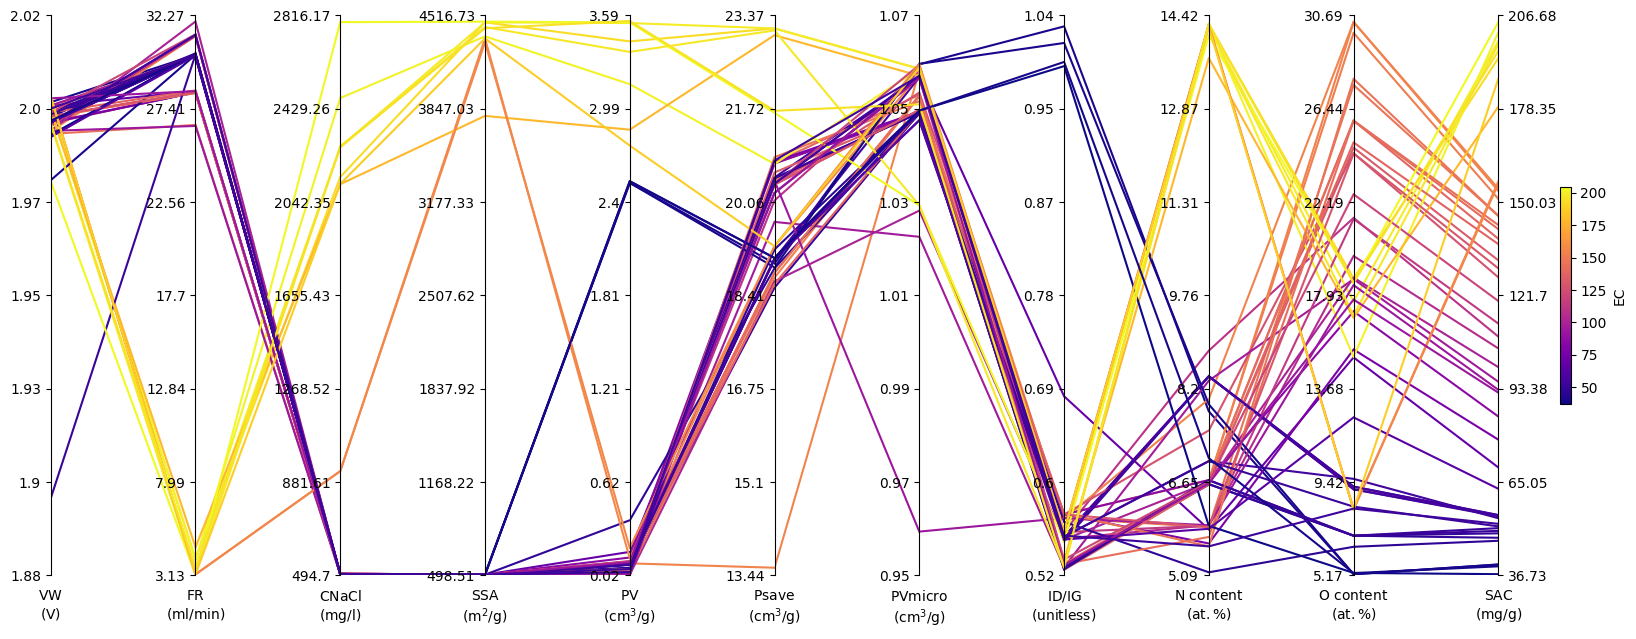

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import paxplot

dd = pd.DataFrame(result.X, columns=training_data.columns)
dd['EC'] = -result.F[:, 0]

cols = dd.columns

# Create figure
paxfig = paxplot.pax_parallel(n_axes=len(cols))
paxfig.plot(dd.to_numpy())

# Add labels
paxfig.set_labels(cols)

# Add colorbar
color_col = len(cols) - 1
paxfig.add_colorbar(ax_idx=color_col, cmap='plasma', colorbar_kwargs={'label': cols[color_col]})

# Set limits for each axis
multiplier = 0.01
lower_limit = {
                'VW': min(dd['VW']) - min(dd['VW'])*multiplier, 'FR': min(dd['FR']) - min(dd['FR'])*multiplier,
                'CNaCl': min(dd['CNaCl']) - min(dd['CNaCl'])*multiplier, 'SSA': min(dd['SSA']) - min(dd['SSA'])*multiplier,
                'PV': min(dd['PV']) - min(dd['PV'])*multiplier, 'Psave': min(dd['Psave']) - min(dd['Psave'])*multiplier,
                'PVmicro': min(dd['PVmicro']) - min(dd['PVmicro'])*multiplier, 'ID/IG': min(dd['ID/IG']) - min(dd['ID/IG'])*multiplier,
                'N': min(dd['N']) - min(dd['N'])*multiplier, 'O': min(dd['O']) - min(dd['O'])*multiplier,
                'EC': min(dd['EC']) - min(dd['EC'])*multiplier
                }

upper_limit = {
                'VW': max(dd['VW']) + max(dd['VW'])*multiplier, 'FR': max(dd['FR']) + max(dd['FR'])*multiplier,
                'CNaCl': max(dd['CNaCl']) + max(dd['CNaCl'])*multiplier, 'SSA': max(dd['SSA']) + max(dd['SSA'])*multiplier,
                'PV': max(dd['PV']) + max(dd['PV'])*multiplier, 'Psave': max(dd['Psave']) + max(dd['Psave'])*multiplier,
                'PVmicro': max(dd['PVmicro']) + max(dd['PVmicro'])*multiplier, 'ID/IG': max(dd['ID/IG']) + max(dd['ID/IG'])*multiplier,
                'N': max(dd['N']) + max(dd['N'])*multiplier, 'O': max(dd['O']) + max(dd['O'])*multiplier,
                'EC': max(dd['EC']) + max(dd['EC'])*multiplier
                }

for idx, col in enumerate(cols):
    paxfig.set_lim(ax_idx=idx, bottom=lower_limit[col], top=upper_limit[col]) 

# set figure size
paxfig.set_size_inches(19, 8)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding

# set labels
all_labels = [
            r'$\rm VW$', r'$\rm FR$', r'$\rm CNaCl$', r'$\rm SSA$', 
            r'$\rm PV$', r'$\rm Psave$', r'$\rm PVmicro$', r'$\rm ID/IG$', 
            r'$\rm N\ content$', r'$\rm O\ content$', r'$\rm SAC$']

all_units = [
            r'$\rm V$', r'$\rm ml/min$', r'$\rm mg/l$', r'$\rm m^{2}/g$', 
            r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm unitless$', 
            r'$\rm at.\%$', r'$\rm at.\%$',  r'$\rm mg/g$']

labels = [f'{all_labels[i]}\n({all_units[i]})' for i in range(len(all_labels))]

paxfig.set_labels(labels)

plt.show()
